In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
import glob
import numpy as np
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Ablation data from Miles et al. and precipitation from Earth Engine
# https://code.earthengine.google.com/eeec44febbbbbe2c1e2c403421e7bb33
df = pd.read_csv('Miles.csv')
df['BalAbl (mm/y)'] = 1e3 * 1e9 * df['BalAbl Gt a-1'] / (1e6 * df['Basin area (km2)'])
df['Precip ERA5-Land (mm/y)'] = 1e3 * df['Precip ERA5-Land'] / ( 1e6 * df['Basin area (km2)'])
df['Precip GPM (mm/y)'] = 1e3 * df['Precip GPM'] / (1e6 * df['Basin area (km2)'])
df['Precip WorldClim (mm/y)'] = 1e3 * df['Precip WorldClim'] / (1e6 * df['Basin area (km2)'])
df['% BalAbl/Precip ERA5-Land'] = 1e2 * df['BalAbl (mm/y)'] / df['Precip ERA5-Land (mm/y)']
df['% BalAbl/Precip GPM'] = 1e2 * df['BalAbl (mm/y)'] / df['Precip GPM (mm/y)']

In [3]:
df.filter(items=[
    'Basin','Basin area (km2)',
    'BalAbl (mm/y)','Precip ERA5-Land (mm/y)', 
    'Precip GPM (mm/y)', 'Precip WorldClim (mm/y)'])

,Basin,Basin area (km2),BalAbl (mm/y),Precip ERA5-Land (mm/y),Precip GPM (mm/y),Precip WorldClim (mm/y)
0,Lake Balkash,445594,1.987908,447.623541,371.458378,286.551867
1,Syr Darya,1117625,0.812974,400.122421,358.534022,261.481801
2,Gobi Interior,2170053,0.425105,218.666720,177.862246,159.699902
3,Amu Darya,799261,4.500407,349.193652,284.697230,296.384522
4,Tarim Interior,1585658,5.283106,253.100173,114.625283,94.001132
5,Tibetan Plateau,405858,1.482292,479.183173,314.102961,214.952246
6,Yangtze,1789482,0.430292,1338.061819,1058.249619,1023.370577
7,Indus,867157,13.342451,655.627931,523.009036,421.390320
8,Ganges - Bramaputra,1671358,5.255607,1612.022978,1333.982270,1214.179116
9,Salween,265822,2.227054,1475.227282,1140.987827,1060.414441


In [4]:
# river basin colors
C = np.array([
    [129,200,118],
    [209,96,226],
    [193,237,121],
    [226,110,123],
    [21,141,210],
    [218,195,15],
    [30,55,212],
    [39,231,109],
    [108,35,233],
    [200,62,149],
    [226,144,93],
])/255

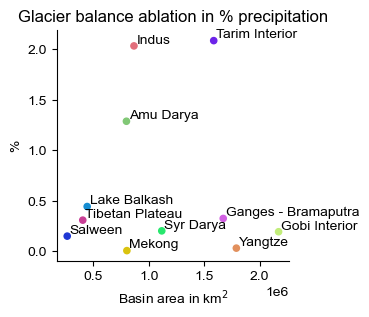

In [5]:
# plot glacier balance ablation vs % precip
plt.rcParams["font.family"] = "Arial"
ax = df.sort_values('Basin').plot.scatter(x='Basin area (km2)',y='% BalAbl/Precip ERA5-Land',
                     c=C,
                     figsize=[3,3]);

for idx, row in df.sort_values('Basin').iterrows():
    ax.annotate(row.Basin, (row['Basin area (km2)'], 
                            row['% BalAbl/Precip ERA5-Land']), 
                xytext=(1.8, 1.8), 
                textcoords='offset points')
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('%');
ax.set_title('Glacier balance ablation in % precipitation');
ax.set_xlabel('Basin area in km$^2$');
plt.savefig('MilesScatter.png', dpi=300, bbox_inches='tight')

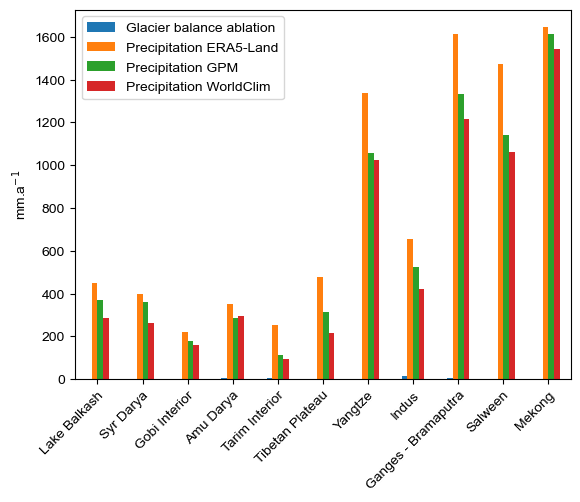

In [6]:
ax = df.filter(items=['BalAbl (mm/y)','Precip ERA5-Land (mm/y)', 'Precip GPM (mm/y)', 'Precip WorldClim (mm/y)']).plot.bar();
ax.set_xticklabels(df.Basin, rotation=45, ha='right', rotation_mode='anchor');
ax.set_yscale('linear')
ax.set_ylabel('mm.a$^{-1}$')
ax.legend(['Glacier balance ablation', 'Precipitation ERA5-Land', 'Precipitation GPM', 'Precipitation WorldClim']);

In [7]:
# impute missing ablation values in Miles et al. table using gradient boosting regressor
# values at non valid points can be huge
# and need to be replaced by reasonable estimates for catchment scale analysis
# Table from https://zenodo.org/record/5119153 
glapt = gpd.read_file('Glaciers_summarytable_20210721.shp')

In [8]:
# train on valid data
ix = glapt['VALID'] == 1
predictors = ['CenLat','CenLon','AAR','meanSMB']
X = glapt.loc[ix,predictors]
y = glapt.loc[ix,'balAbl']
print(f'missing fraction {sum(~ix)/len(ix)}')

missing fraction 0.3204099271515002


In [9]:
# keep 20% data for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13)

In [10]:
# fit and predict
reg = ensemble.HistGradientBoostingRegressor()
reg.fit(X_train, y_train)
p = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, p))

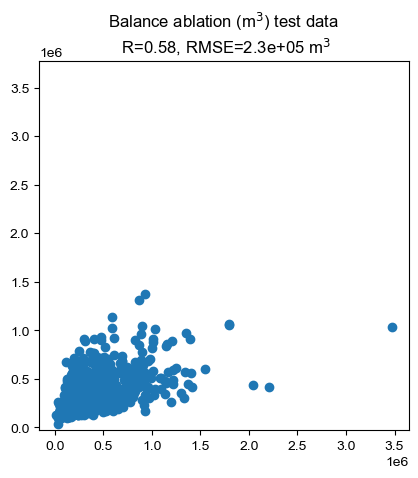

In [11]:
# plot fit vs. test data
plt.scatter(-1*(y_test), -1*(p))
plt.axis('square')
plt.title('Balance ablation (m$^3$) test data \n R={:.2f}, RMSE={:.1e} m$^3$'.format(
    np.corrcoef(y_test, p)[0,1],rmse));

In [12]:
# predict values of non valid
Xnv = glapt.loc[~ix,predictors]
glapt.loc[~ix,'balAbl'] = reg.predict(Xnv)

In [13]:
# save to shapefile
glapt.to_file('Glaciers_summarytable_20210721_filled.shp')

Add sum of BalAbl to HydroBASINS polygons using SAGA points-in-polygon tool, run in QGIS with
batch processing tool to process polygons of catchment with Pfaf. level 03 to 09).

https://www.hydrosheds.org/products/hydrobasins

e.g. 
`
shapes_polygons "Point Statistics for Polygons" -POINTS "Glaciers_summarytable_20210721_filled.shp" -POLYGONS "hybas_as_lev08_v1c.shp" -FIELDS "balAbl" -FIELD_NAME 0 -SUM true -AVG false -VAR false -DEV false -MIN false -MAX false -NUM true -STATISTICS ".hybas_balAbl/valid/filled/stathybas_as_lev08_v1c_8f385c84_bf4d_4ea2_95aa_cfbc4b9d9656.shp"
`

In [14]:
# read HydroBASINS shapefiles
gdf_list_balAbl_filled = list()
for i in range(3,10):
    f = glob.glob(f'hybas_balAbl/valid/filled/stathybas_as_lev0{i}*.shp')[0]
    g = gpd.read_file(f)
    g['level'] = i
    gdf_list_balAbl_filled.append(g)

In [15]:
# combine to a single geodataframe
gdfv = pd.concat(gdf_list_balAbl_filled,ignore_index=True)

In [16]:
# express ablation as a positive value
gdfv['SUM_balAbl'] = abs(gdfv['SUM_balAbl'])

In [17]:
# select glacierized catchment
ix = gdfv['NUM_balAbl']>0

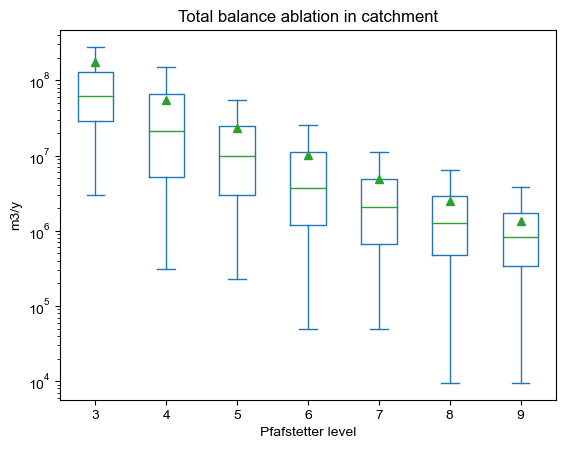

In [18]:
# volume by catchment
gdfv.loc[ix].plot.box(column="SUM_balAbl", by="level",showmeans=True, showfliers=False, logy=True);
plt.ylabel('m3/y')
plt.xlabel('Pfafstetter level')
plt.title('Total balance ablation in catchment');

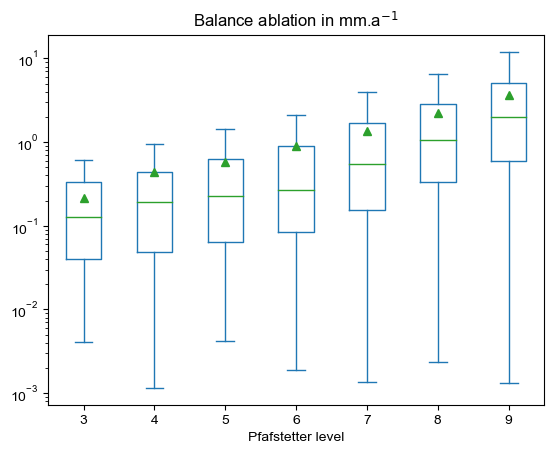

In [19]:
# specific value in mm/y
gdfv['SPE_balAbl'] = 1e3*gdfv['SUM_balAbl']/(gdfv['UP_AREA']*1e6)
gdfv.plot.box(column="SPE_balAbl", by="level",showfliers=False, showmeans=True, logy=True);
plt.xlabel('Pfafstetter level')
plt.title('Balance ablation in mm.a$^{-1}$');

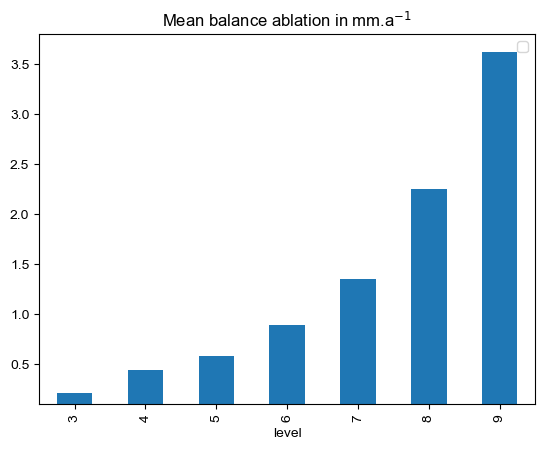

In [20]:
gdfv.groupby('level').mean(numeric_only=True).plot.bar(y='SPE_balAbl',logy=False);
plt.ylim(bottom=0.1);
plt.title('Mean balance ablation in mm.a$^{-1}$');
plt.legend('');

In [21]:
# create area bins 
gdfv['areabins'] = pd.qcut(gdfv.UP_AREA, 8, precision=1)

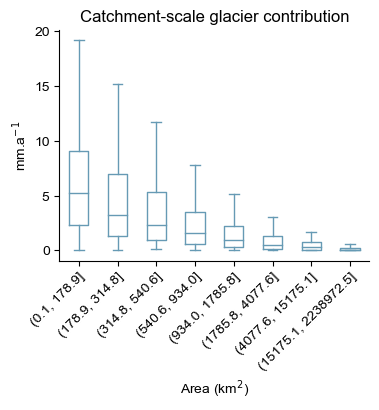

In [22]:
# plot balance ablation by area
gdfv.plot.box(column="SPE_balAbl", by="areabins",showfliers=False, showmeans=False, logy=False, figsize=[4,3], color='#669ab4');
plt.xlabel('Area (km$^2$)')
plt.title('Catchment-scale glacier contribution');
plt.xticks(rotation=45, ha='right', rotation_mode='anchor');
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('mm.a$^{-1}$');
plt.savefig('MilesArea.png', dpi=300, bbox_inches='tight')

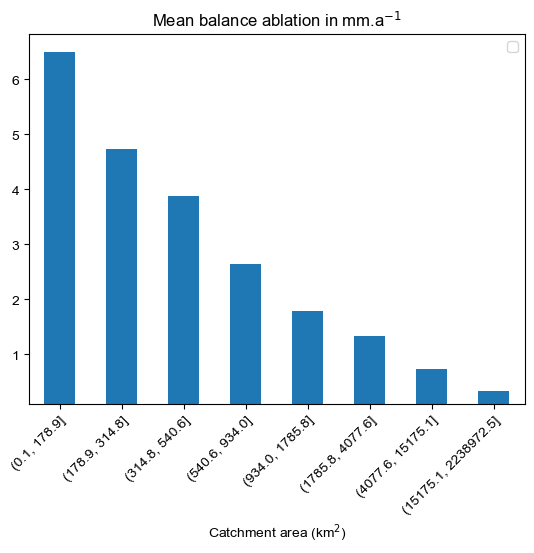

In [23]:
gdfv.groupby('areabins').mean(numeric_only=True).plot.bar(y='SPE_balAbl',logy=False);
plt.xlabel('Catchment area (km$^2$)')
plt.title('Mean balance ablation in mm.a$^{-1}$');
plt.ylim(bottom=0.1)
plt.legend('')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor');

In [24]:
indus = gdfv.loc[gdfv.PFAF_ID == 456]
glaindus = gpd.sjoin(glapt, indus)

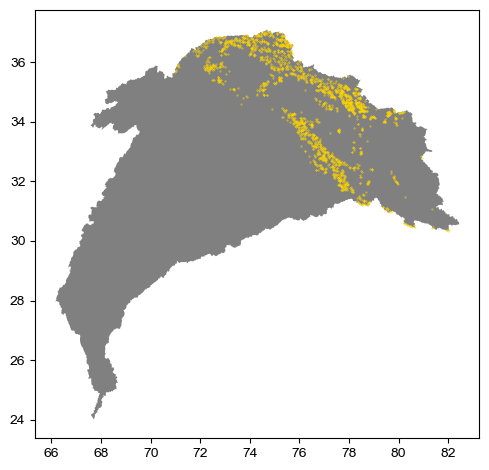

In [25]:
fig, ax = plt.subplots()
indus.plot(ax=ax, facecolor='gray');
glaindus.plot(ax=ax, color='gold', markersize=.1);
plt.tight_layout();

In [26]:
ix = glaindus.VALID==1
1e3*glaindus.balAbl[ix].sum()/(indus.SUB_AREA*1e6)

20   -0.578728
Name: SUB_AREA, dtype: float64

In [27]:
1e3*glaindus.balAbl.sum()/(indus.UP_AREA*1e6)

20   -0.850706
Name: UP_AREA, dtype: float64